In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import ImageEnhance, Image
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import time
from sklearn.decomposition import PCA
from glob import iglob
import kornia as K

## Data Exploration

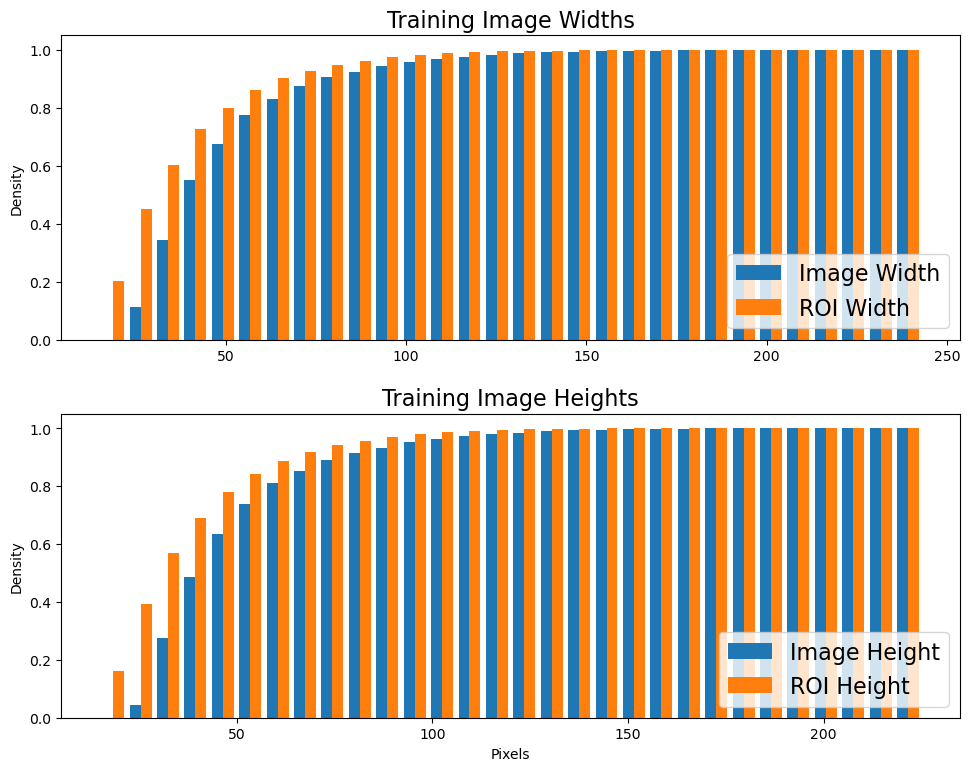

In [2]:
# data exploration
# first see the number of images in different classes
training_csv = pd.read_csv('./dataset/Train.csv')
width = training_csv['Width']
height = training_csv['Height']
roi_x = training_csv['Roi.X2'] - training_csv['Roi.X1']
roi_y = training_csv['Roi.Y2'] - training_csv['Roi.Y1']
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,8))
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax1.hist([width, roi_x], bins=30, density=True,label=['Image Width', 'ROI Width'], cumulative=True)
ax1.legend(loc='lower right')
ax2.hist([height, roi_y], bins=30, density=True,label=['Image Height', 'ROI Height'], cumulative=True)
ax2.legend(loc='lower right')
ax2.set_xlabel('Pixels')
ax1.set_ylabel('Density')
ax1.set_title('Training Image Widths')
ax2.set_ylabel('Density')
ax2.set_title('Training Image Heights')
# note that the classes are imbalanced
fig.tight_layout()
plt.show()

39209


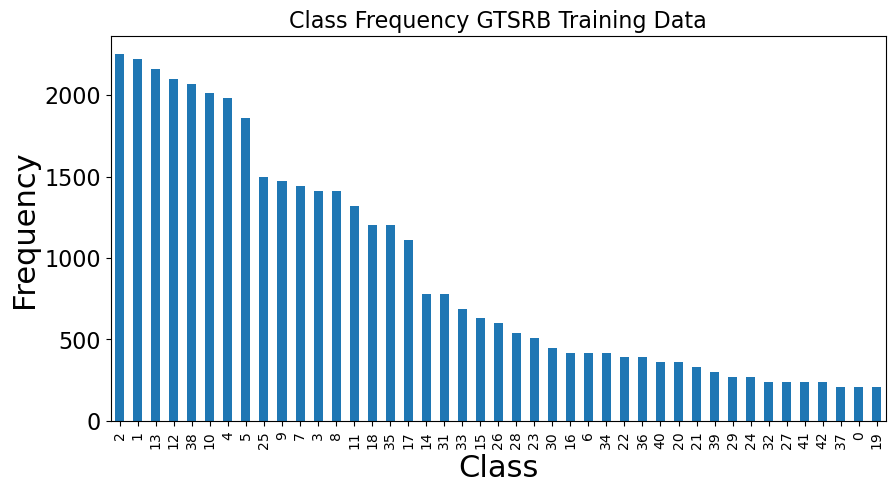

In [3]:
classes_training = training_csv['ClassId']
fig, ax = plt.subplots(1,1, figsize=(10,5))
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
print(len(classes_training))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
classes_training.value_counts().plot(kind='bar');
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Class Frequency GTSRB Training Data')
# note that the classes are imbalanced
plt.show()

## Model Building and Training

In [56]:
base_transforms = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.ToTensor(),
    ])
augment_transforms_1 = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.RandomEqualize(p=1),
    transforms.ToTensor(),
    ])
augment_transforms_2 = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    ])
augment_transforms_3 = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.ToTensor(),
    ])
augment_transforms_4 = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    ])
augment_transforms_5 = transforms.Compose([
    transforms.Resize([227,227]),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    ])

In [57]:
BATCH_SIZE = 256
learning_rate = 0.002
EPOCHS = 20
numClasses = 43

In [58]:
train_data_path = "./dataset/TRAIN/"
train_data_base = torchvision.datasets.ImageFolder(root = train_data_path, transform = base_transforms)
train_data_aug_1 = torchvision.datasets.ImageFolder(root = train_data_path, transform = augment_transforms_1)
train_data_aug_2 = torchvision.datasets.ImageFolder(root = train_data_path, transform = augment_transforms_2)
train_data_aug_3 = torchvision.datasets.ImageFolder(root = train_data_path, transform = augment_transforms_3)
train_data_aug_4 = torchvision.datasets.ImageFolder(root = train_data_path, transform = augment_transforms_4)
train_data_aug_5 = torchvision.datasets.ImageFolder(root = train_data_path, transform = augment_transforms_5)

train_data_raw = torch.utils.data.ConcatDataset([train_data_base, train_data_aug_1, train_data_aug_2, train_data_aug_3, train_data_aug_4, train_data_aug_5])
train_data_raw = train_data_base
print(len(train_data_raw))
# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data_raw) * ratio)
n_val_examples = len(train_data_raw) - n_train_examples

train_data, val_data = data.random_split(train_data_raw, [n_train_examples, n_val_examples])


# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

39209


In [59]:
from sklearn.utils.class_weight import compute_class_weight
training_csv = pd.read_csv('./dataset/Train.csv')
classes_training = training_csv['ClassId']
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(classes_training),y=classes_training)
class_weights=torch.tensor(class_weights,dtype=torch.float).cuda()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [60]:
# here we specify which model to use
model = 227
from class_alexnetTS112 import AlexnetTS112
from class_alexnetTS227 import AlexnetTS227
from torchsummary import summary
if model == 112:
    model = AlexnetTS112(numClasses)
else:
    model = AlexnetTS227(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 58,460,267 trainable parameters


In [61]:
should_use_class_weights = 1
if should_use_class_weights == 1:
    criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
else:
    criterion = nn.CrossEntropyLoss()

In [62]:
torch.cuda.is_available()

True

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.to(device)
    criterion = nn.DataParallel(criterion)
    criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
print(model)

DataParallel(
  (module): AlexnetTS227(
    (layer1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(384, eps=1e-05, 

In [65]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [66]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Training pass
        opt.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.sum().backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.sum()
        epoch_acc += acc.sum()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [67]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Run predictions
            
            output= model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.sum()
            epoch_acc += acc.sum()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [68]:
# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 8.7877, Accuracy = 0.0403, Time = 245.12 seconds
Validation: Loss = 6.3713, Accuracy = 0.0600, Time = 63.25 seconds

Epoch-1: 
Training: Loss = 6.5572, Accuracy = 0.0616, Time = 59.52 seconds
Validation: Loss = 5.5157, Accuracy = 0.1166, Time = 14.44 seconds

Epoch-2: 
Training: Loss = 6.1458, Accuracy = 0.0923, Time = 53.96 seconds
Validation: Loss = 5.1997, Accuracy = 0.1896, Time = 12.01 seconds

Epoch-3: 
Training: Loss = 5.8585, Accuracy = 0.1235, Time = 54.42 seconds
Validation: Loss = 4.9674, Accuracy = 0.1851, Time = 12.33 seconds

Epoch-4: 
Training: Loss = 5.6677, Accuracy = 0.1360, Time = 49.81 seconds
Validation: Loss = 5.0493, Accuracy = 0.1751, Time = 11.51 seconds

Epoch-5: 
Training: Loss = 5.5449, Accuracy = 0.1466, Time = 49.69 seconds
Validation: Loss = 4.7473, Accuracy = 0.2358, Time = 12.44 seconds

Epoch-6: 
Training: Loss = 5.4860, Accuracy = 0.1591, Time = 50.09 seconds
Validation: Loss = 4.6221, Accuracy = 0.2585, Time = 12.37 seconds

In [69]:
# Saving the model

# Create folder to save model
MODEL_FOLDER = "./models_227"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/CLASS_WEIGHTS_ONLY.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.module.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at ./models_227/CLASS_WEIGHTS_ONLY.pth
